<a href="https://colab.research.google.com/github/EldarImanbekov/Projects/blob/main/Bishkek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have dataset of Bishkek's air quality since 2019 till early 2024. We will start by combining the csv files into one.

In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

file_paths = ["Bishkek_PM2.5_2019_YTD.csv", "Bishkek_PM2.5_2020_YTD.csv", "Bishkek_PM2.5_2021_YTD.csv",
              "Bishkek_PM2.5_2022_YTD.csv", "Bishkek_PM2.5_2023_YTD.csv", "Bishkek_PM2.5_2024_02_MTD.csv", "Bishkek_PM2.5_2024_YTD.csv"]

dfs = [pd.read_csv(file) for file in file_paths]

combined_df = pd.concat(dfs, ignore_index=True)

combined_df['Date (LT)'] = pd.to_datetime(combined_df['Date (LT)'])

combined_df = combined_df.sort_values(by='Date (LT)')

df = combined_df

combined_df.to_csv("combined_air_quality.csv", index=False)

df = df.set_index('Date (LT)')


Here, I've dropped the rows with NaN values (-999 in this case)

In [ ]:
columns_to_drop = ["AQI Category", "QC Name", "Conc. Unit", "Duration", "NowCast Conc.", "Parameter", "Raw Conc."]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
df.head()

,Site,Year,Month,Day,Hour,AQI
Date (LT),,,,,,
2019-02-06 06:00:00,Bishkek,2019,2,6,6,-999
2019-02-06 07:00:00,Bishkek,2019,2,6,7,61
2019-02-06 08:00:00,Bishkek,2019,2,6,8,66
2019-02-06 09:00:00,Bishkek,2019,2,6,9,73
2019-02-06 10:00:00,Bishkek,2019,2,6,10,91


In [ ]:
df.replace(-999, np.nan, inplace=True)
df.dropna(inplace=True)
df.head()

,Site,Year,Month,Day,Hour,AQI
Date (LT),,,,,,
2019-02-06 07:00:00,Bishkek,2019,2,6,7,61.0
2019-02-06 08:00:00,Bishkek,2019,2,6,8,66.0
2019-02-06 09:00:00,Bishkek,2019,2,6,9,73.0
2019-02-06 10:00:00,Bishkek,2019,2,6,10,91.0
2019-02-06 11:00:00,Bishkek,2019,2,6,11,99.0


In [ ]:
def assign_season(row):
    month = row["Month"]
    year = row["Year"]

    if month in [6, 7, 8]:
        return f"Summer {year}"
    elif month == 12:
        return f"Winter {year + 1}"
    elif month in [1, 2]:
        return f"Winter {year}"
    elif month in [3, 4, 5]:
        return f"Spring {year}"
    elif month in [9, 10, 11]:
        return f"Fall {year}"


df['Year'] = df.index.year
df['Month'] = df.index.month
df['Season'] = df.apply(assign_season, axis=1)
df_seasonal = df.dropna(subset=['Season'])
seasonal_avg = df_seasonal.groupby(['Year', 'Season'])['AQI'].mean()
seasonal_avg = seasonal_avg.reset_index().sort_values(by=['Year', 'Season'])

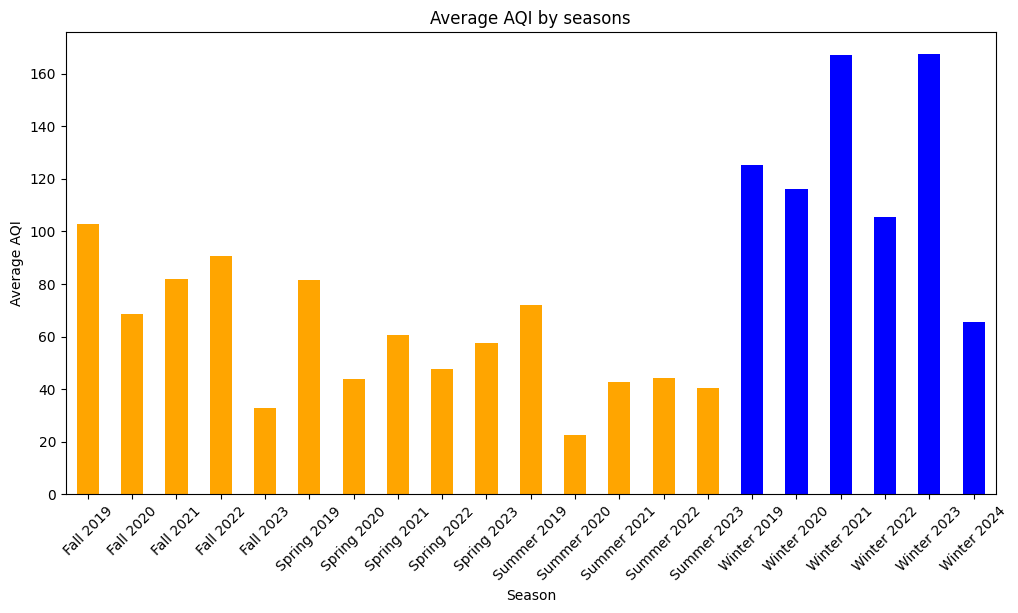

In [ ]:
seasonal_avg = df_seasonal.groupby('Season')['AQI'].mean()

plt.figure(figsize=(12,6))
seasonal_avg.plot(kind='bar', color=['blue' if 'Winter' in s else 'orange' for s in seasonal_avg.index])
plt.title("Average AQI by seasons")
plt.xlabel("Season")
plt.ylabel("Average AQI")
plt.xticks(rotation=45)
plt.show()

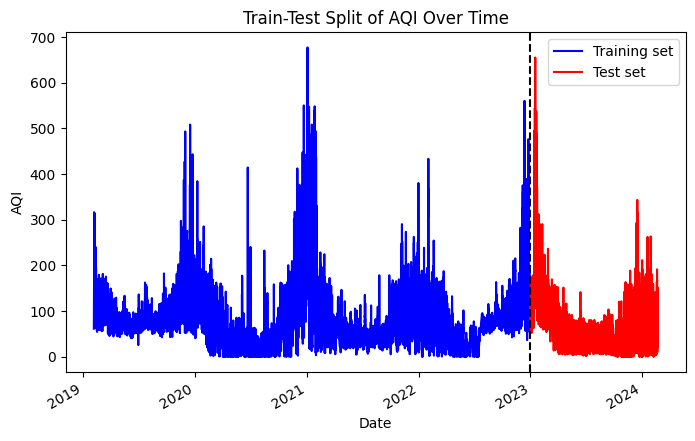

In [ ]:
train = df.loc[df.index < '2023-01-01']
test = df.loc[df.index >= '2023-01-01']

fig, ax = plt.subplots(figsize=(8,5))

train['AQI'].plot(ax=ax, label='Training set', color='blue')
test['AQI'].plot(ax=ax, label='Test set', color='red')
ax.axvline('01-01-2023', color = 'black', ls = '--')

plt.title("Train-Test Split of AQI Over Time")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.show()

<Axes: title={'center': 'AQI in some Winter week'}, xlabel='Date (LT)'>

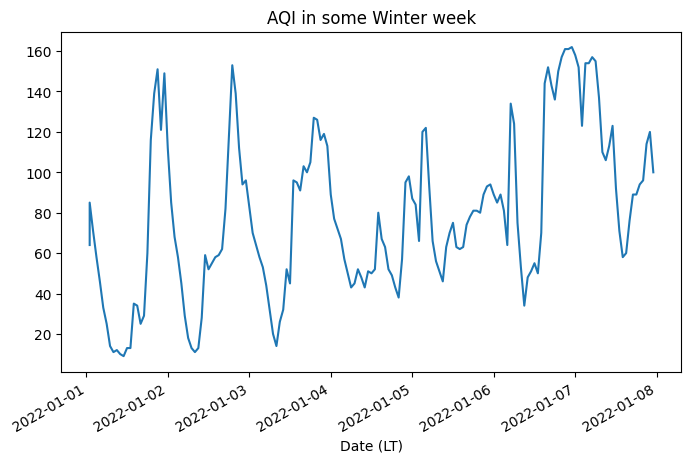

In [ ]:
df.loc[(df.index > '01-01-2022') & (df.index < '01-08-2022'), 'AQI'].plot(figsize = (8, 5), title = 'AQI in some Winter week')

<Axes: title={'center': 'AQI in some Summer week'}, xlabel='Date (LT)'>

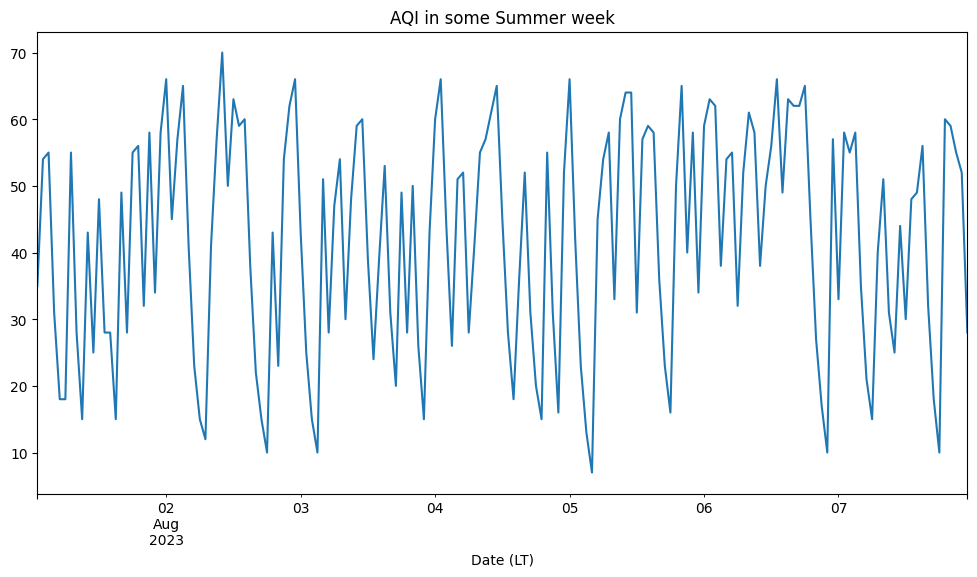

In [ ]:
df.loc[(df.index > '08-01-2023') & (df.index < '08-08-2023'), 'AQI'].plot(figsize = (12, 6), title = 'AQI in some Summer week')

<Axes: title={'center': 'AQI in some Summer week'}, xlabel='Date (LT)'>

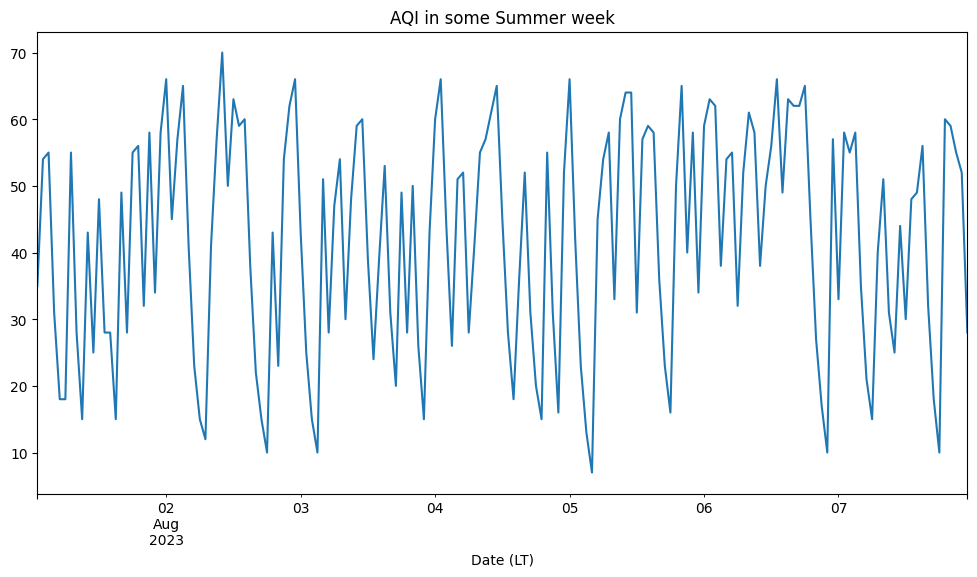

In [ ]:
df.loc[(df.index > '08-01-2023') & (df.index < '08-08-2023'), 'AQI'].plot(figsize = (12, 6), title = 'AQI in some Summer week')

In [ ]:
def create_features(df):
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.hour
  return df

df = create_features(df)


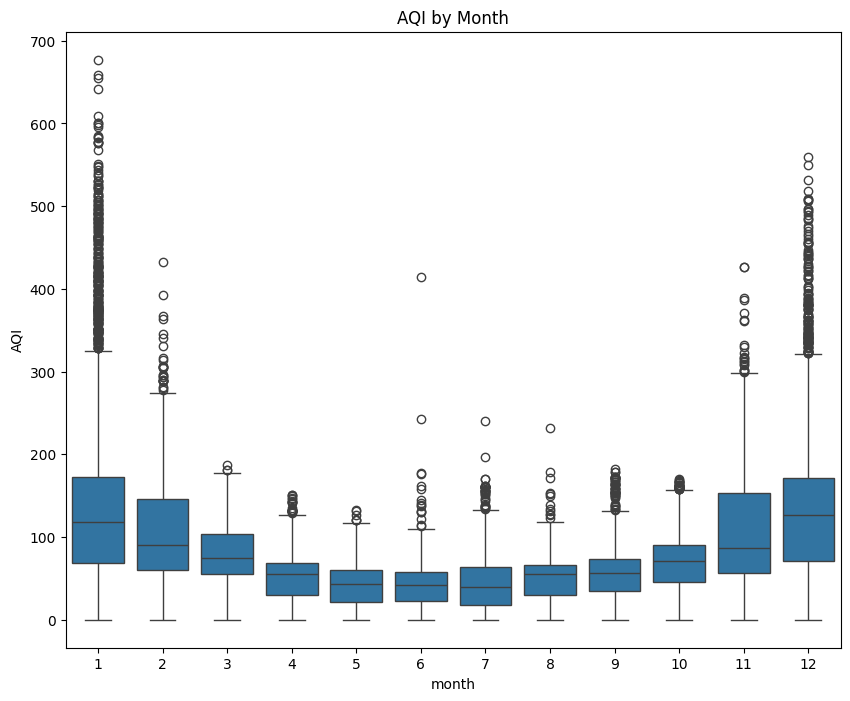

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y = 'AQI')
plt.title("AQI by Month")
plt.show()

In [ ]:
train = create_features(train)
test = create_features(test)

In [ ]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'AQI'

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate = 0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose = 100)
reg.score(X_test, y_test)

[0]	validation_0-rmse:61.94786	validation_1-rmse:66.90703
[99]	validation_0-rmse:44.86528	validation_1-rmse:66.00995


0.0003699731707986764

Feature Importance

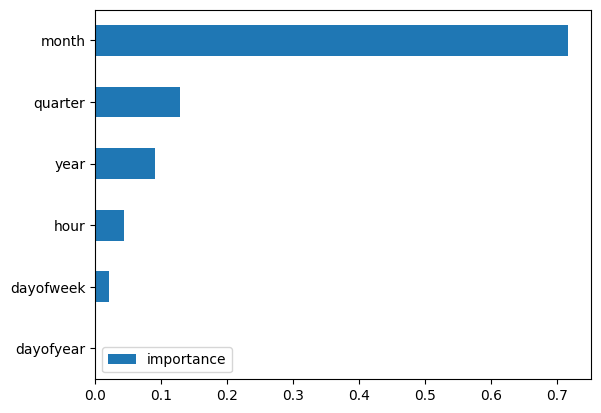

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh')
plt.show()

Forecast

In [ ]:
test['predictions'] = reg.predict(X_test)
df = df.merge(test[['predictions']], how='left', left_index=True, right_index=True)

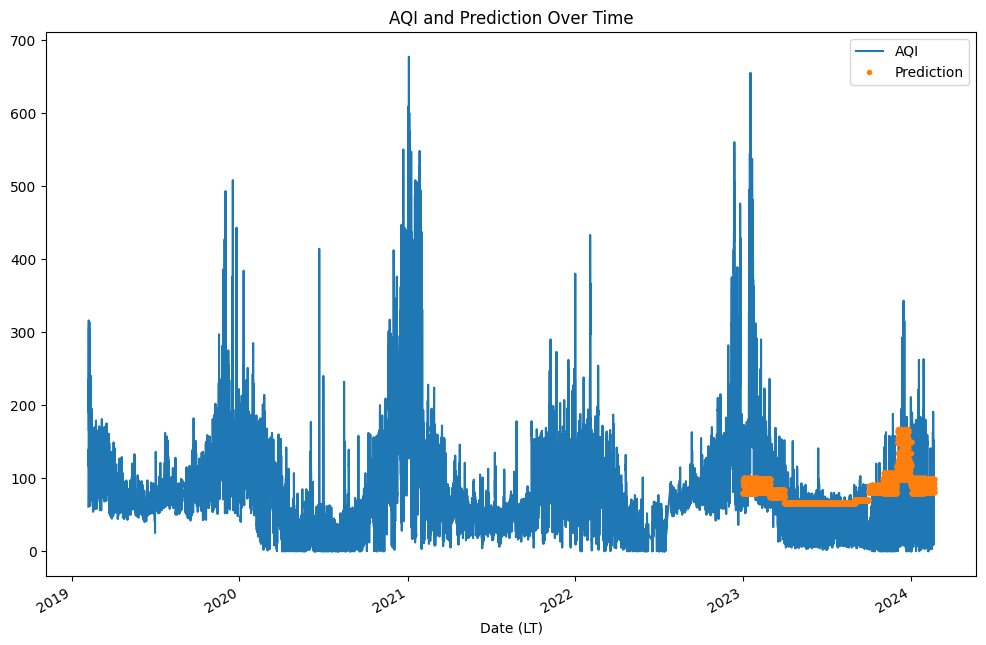

In [ ]:
ax = df[['AQI']].plot(figsize=(12, 8))
test['predictions'].plot(ax=ax, style='.')
plt.legend(['AQI', 'Prediction'])
plt.title('AQI and Prediction Over Time')
plt.show()